# Tutorial to build distribution map published at [Farroñay et al. (2018)](https://biotaxa.org/Phytotaxa/article/view/phytotaxa.361.1.8)
## Author: [Ricardo de Oliveira Perdiz](https://github.com/ricoperdiz/CV)

## 01 Load packages

In [11]:
library('dplyr')
library('stringr')
library('readr')
library('purrr')
library('magrittr')
library('broom')
library('rgdal')
library('measurements')
library('GISTools')
library('ggmap')
library('ggsn')
library('cowplot')

## 02 Read data

### Specimen data

In [12]:
# Macrolobium longipes
nybg <- read_delim('nybg.csv', delim = ',')
splink <- read_delim('splink.csv', delim = ';')
inpa <- read_delim('inpa.csv', delim = ',')

Parsed with column specification:
cols(
  .default = col_character(),
  DarCatalogNumber = col_double(),
  DarCollector = col_double(),
  DarYearCollected = col_double(),
  DarMinimumElevation = col_logical(),
  DarMaximumElevation = col_logical(),
  DarDecimalLatitude = col_double(),
  DarDecimalLongitude = col_double(),
  DarGeorefMethod = col_logical(),
  DarCoordinateUncertaintyInMeter = col_double(),
  DarSubspecies = col_logical(),
  DarInfraspecificEpithet = col_logical()
)
See spec(...) for full column specifications.
Warning message:
“4 parsing failures.
row col   expected     actual       file
  1  -- 33 columns 31 columns 'nybg.csv'
  2  -- 33 columns 31 columns 'nybg.csv'
  3  -- 33 columns 31 columns 'nybg.csv'
  4  -- 33 columns 31 columns 'nybg.csv'
”Parsed with column specification:
cols(
  .default = col_logical(),
  datelastmodified = col_date(format = ""),
  institutioncode = col_character(),
  kingdom = col_character(),
  descrindividuo = col_character(),
  codcolbo

In [13]:
# Macrolobium aracaense
araca <- read_delim('Maracaense.csv', delim = '\t')

Parsed with column specification:
cols(
  COLETOR = col_character(),
  NUMERO = col_double(),
  SP1 = col_logical(),
  COLDD = col_double(),
  COLM = col_double(),
  COLY = col_double(),
  ADDCOLL = col_character(),
  COUNTRY = col_character(),
  MINORAREA = col_character(),
  MAJORAREA = col_character(),
  GAZETTER = col_character(),
  COORDENADAS = col_character(),
  LATITUDE = col_double(),
  LONGITUDE = col_double(),
  HERBARIA = col_character(),
  DESC_PLANT = col_character(),
  DESC_HABITAT = col_character()
)


### GIS data

In [14]:
# South and Central America shape
area_mapa <- rgdal::readOGR(dsn = 'SAm_CAm_shape.shp')

OGR data source with driver: ESRI Shapefile 
Source: "/Users/ricoperdiz/Documents/Tutorials/R_map_for_Farronayetal_2018/SAm_CAm_shape.shp", layer: "SAm_CAm_shape"
with 37 features
It has 65 fields


In [15]:
# Brazilian states shapefile
estados <- rgdal::readOGR(dsn = 'BRASIL.shp')
estados %>% summary

OGR data source with driver: ESRI Shapefile 
Source: "/Users/ricoperdiz/Documents/Tutorials/R_map_for_Farronayetal_2018/BRASIL.shp", layer: "BRASIL"
with 27 features
It has 3 fields


Object of class SpatialPolygonsDataFrame
Coordinates:
        min       max
x -73.83943 -34.85810
y -33.77086   5.38289
Is projected: NA 
proj4string : [NA]
Data attributes:
       UF          ESTADO   REGIAO
 AC     : 1   Acre    : 1   CO:4  
 AL     : 1   Alagoas : 1   NE:9  
 AM     : 1   Amap\xa0: 1   NO:7  
 AP     : 1   Amazonas: 1   SE:4  
 BA     : 1   Bahia   : 1   SU:3  
 CE     : 1   Cear\xa0: 1         
 (Other):21   (Other) :21         

In [16]:
br_amazonas <- estados[grep('Amazonas', estados$ESTADO, ignore.case = T),]

Warning message in grep("Amazonas", estados$ESTADO, ignore.case = T):
“input string 3 is invalid in this locale”Warning message in grep("Amazonas", estados$ESTADO, ignore.case = T):
“input string 6 is invalid in this locale”Warning message in grep("Amazonas", estados$ESTADO, ignore.case = T):
“input string 8 is invalid in this locale”Warning message in grep("Amazonas", estados$ESTADO, ignore.case = T):
“input string 9 is invalid in this locale”Warning message in grep("Amazonas", estados$ESTADO, ignore.case = T):
“input string 10 is invalid in this locale”

In [17]:
br_amazonas_tidy <- tidy(br_amazonas)
area_mapa_tidy <- tidy(area_mapa)

Regions defined for each Polygons
Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“

“binding character and factor vector, coercing into character vector”Regions defined for each Polygons


## 03 Clean data

First, let's clean data for the species *Macrolobium longipes*

In [18]:
# Macrolobium longipes
# first data from inpa
longipes <- inpa %>% 
    mutate(
        lat = str_split(COORD_, 'N') %>%
            sapply('[[', 1 ) %>%
            gsub('°' , ' ', .) %>% 
            gsub("’", " ", .) %>% 
            paste0(., ' 0') %>%
            gsub("  |   ", " ", .) %>% 
            str_trim('both') %>% 
            measurements::conv_unit(., from = 'deg_min_sec', to = 'dec_deg'),
        long = str_split(COORD_, 'N') %>%
            sapply('[[', 2) %>% 
            gsub('°' , ' ', .) %>% 
            gsub("’", " ", .) %>% 
            gsub('W', '0', .) %>% 
            str_trim('both') %>% 
            gsub("  ", " ", .) %>% 
            measurements::conv_unit(., from = 'deg_min_sec', to = 'dec_deg')
            ) %>% 
    dplyr::select(-COORD_)

In [19]:
names(longipes) <- tolower(names(longipes)) # turn all column names as lower case

In [20]:
# then we clean data downloaded from splink
longipes <- splink %>% 
    dplyr::select(herbaria = institutioncode,
           coletor, numero_col = numcoleta,
           especie = taxoncompleto,
           pais, estado = estado_prov,
           local = descrlocal) %>% 
    full_join(longipes, .) %>% 
    dplyr::select(-estado)

Joining, by = c("herbaria", "coletor", "numero_col", "especie")


In [21]:
# at last, let's clean data downloaded from nybg
nybg_modif <- nybg %>% 
    dplyr::select(herbaria = DarInstitutionCode,
           coletor = DarCollectorNumber,
           numero_col = DarCollector,
           local = DarLocality,
           lat = DarDecimalLatitude,
           long = DarDecimalLongitude,
           pais = DarCountry)

It is **always good** to take a **look at our data**, see column data types, how many observations and variables etc.

In [22]:
longipes %>% glimpse

Observations: 6
Variables: 8
$ herbaria   <chr> "INPA", "INPA", "JBRJ", "JBRJ", "JBRJ", "JBRJ"
$ coletor    <chr> "Huber", "Rodrigues", "Maguire, B.", "Maguire, B.", "Magui…
$ numero_col <dbl> 5849, 10875, 37590, 37572, 37643, 37590
$ especie    <chr> "Macrolobium longipes", "Macrolobium longipes", "Macrolobi…
$ lat        <chr> "1.58333333333333", "0.333333333333333", NA, NA, NA, NA
$ long       <chr> "66.55", "67.3166666666667", NA, NA, NA, NA
$ pais       <chr> NA, NA, "Venezuela", "Venezuela", "Venezuela", "Venezuela"
$ local      <chr> NA, NA, "Rio Siapa, Casiquiare, Territorio Amazonas. ", "R…


In [23]:
nybg_modif %>% glimpse

Observations: 4
Variables: 7
$ herbaria   <chr> "NY", "NY", "NY", "NY"
$ coletor    <chr> "H. C. de Lima", "B. Maguire", "B. Maguire", "W. A. Rodrig…
$ numero_col <dbl> 3279, 37590, 37590, 10875
$ local      <chr> "Alto Rio Negro, Rio Uaupés, Igarapé Tibuarí, acima do Ser…
$ lat        <dbl> -0.130278, NA, NA, 0.333333
$ long       <dbl> -67.0892, NA, NA, -67.3167
$ pais       <chr> "Brazil", "Venezuela", "Venezuela", "Brazil"


In [24]:
longipes <- longipes %>%  
    mutate_at(
        .vars = c('lat', 'long'),
        .funs = as.numeric
    ) %>% 
    full_join(., nybg_modif)

Joining, by = c("herbaria", "coletor", "numero_col", "lat", "long", "pais", "local")


In [25]:
# filtra os dados para plotar
longipes <- longipes %>% 
    filter(!is.na(lat), coletor != 'Rodrigues') %>% 
# acrescenta o nome da especie na coluna
    mutate(
        especie = 'M. longipes'
    )

Now let's clean data that refers to the new species described in Farronay et al. (2018), called *Macrolobium aracaense* Farroñay.

In [26]:
# Macrolobium aracaense
names(araca) <- tolower(names(araca))
araca_md <- araca %>% 
    mutate(
        lat = str_split(coordenadas, 'N') %>%
            sapply('[[', 1 ) %>%
            gsub('°' , ' ', .) %>% 
            gsub("\'|\'\'|\"", " ", .) %>% 
            gsub("  |   ", " ", .) %>% 
            str_trim('both') %>% 
            measurements::conv_unit(., from = 'deg_min_sec', to = 'dec_deg'),
        long = str_split(coordenadas, 'N') %>%
            sapply('[[', 2 ) %>%
            gsub('W', '', .) %>% 
            gsub('°' , ' ', .) %>% 
            gsub("\'|\'\'|\"", " ", .) %>% 
            gsub("  |   ", " ", .) %>% 
            str_trim('both') %>% 
            measurements::conv_unit(., from = 'deg_min_sec', to = 'dec_deg'),
        especie = 'M. aracaense'
    ) %>% 
    dplyr::select(coletor, numero_col = numero, 
                  pais = country,
                  lat, long, estado = majorarea, herbaria, especie) %>% 
    mutate_at(
        .vars = c('lat', 'long'),
        .funs = as.numeric
        )
araca_md

coletor,numero_col,pais,lat,long,estado,herbaria,especie
"Vicentini, A.",1886,Brasil,0.9483333,63.39167,Amazonas,INPA,M. aracaense
"Farroñay, F.",178,Brasil,0.8633333,63.33167,Amazonas,INPA,M. aracaense


In [27]:
# join data for Macrolobium longipes and M. aracaense
dados <- full_join(longipes, araca_md)
dados %>% glimpse

Joining, by = c("herbaria", "coletor", "numero_col", "especie", "lat", "long", "pais")


Observations: 5
Variables: 9
$ herbaria   <chr> "INPA", "NY", "NY", "INPA", "INPA"
$ coletor    <chr> "Huber", "H. C. de Lima", "W. A. Rodrigues", "Vicentini, A…
$ numero_col <dbl> 5849, 3279, 10875, 1886, 178
$ especie    <chr> "M. longipes", "M. longipes", "M. longipes", "M. aracaense…
$ lat        <dbl> 1.5833333, -0.1302780, 0.3333330, 0.9483333, 0.8633333
$ long       <dbl> 66.55000, -67.08920, -67.31670, 63.39167, 63.33167
$ pais       <chr> NA, "Brazil", "Brazil", "Brasil", "Brasil"
$ local      <chr> NA, "Alto Rio Negro, Rio Uaupés, Igarapé Tibuarí, acima do…
$ estado     <chr> NA, NA, NA, "Amazonas", "Amazonas"


In [28]:
dados$long <- ifelse(dados$long > 0, dados$long * -1, dados$long)

longipes <- dados %>% 
    filter(especie == 'M. longipes')
aracaense <- dados %>% 
    filter(especie == 'M. aracaense')


Now we have two objects containing cleaned data for each species, *Macrolobium longipes* and *M. aracaense*.

In [29]:
longipes %>% glimpse

Observations: 3
Variables: 9
$ herbaria   <chr> "INPA", "NY", "NY"
$ coletor    <chr> "Huber", "H. C. de Lima", "W. A. Rodrigues"
$ numero_col <dbl> 5849, 3279, 10875
$ especie    <chr> "M. longipes", "M. longipes", "M. longipes"
$ lat        <dbl> 1.583333, -0.130278, 0.333333
$ long       <dbl> -66.5500, -67.0892, -67.3167
$ pais       <chr> NA, "Brazil", "Brazil"
$ local      <chr> NA, "Alto Rio Negro, Rio Uaupés, Igarapé Tibuarí, acima do…
$ estado     <chr> NA, NA, NA


In [30]:
aracaense %>% glimpse

Observations: 2
Variables: 9
$ herbaria   <chr> "INPA", "INPA"
$ coletor    <chr> "Vicentini, A.", "Farroñay, F."
$ numero_col <dbl> 1886, 178
$ especie    <chr> "M. aracaense", "M. aracaense"
$ lat        <dbl> 0.9483333, 0.8633333
$ long       <dbl> -63.39167, -63.33167
$ pais       <chr> "Brasil", "Brasil"
$ local      <chr> NA, NA
$ estado     <chr> "Amazonas", "Amazonas"


#### 04 Create variables for the map

In [31]:
# longitude range - main map
x1 <- br_amazonas@bbox[1,]
y1 <- br_amazonas@bbox[2,]

# longitude and latitude range - for ggmap
lat_long <- dados
y_geral <- range(lat_long$lat) + c(-0.01,0.01)
x_geral <- range(lat_long$long) + c(-0.01,0.01)


## 05 Download Google map using R package *ggmap*

Nowadays, in order to download Google maps, you need to obtain a Google Key and set it with the function in the cell below. After that, you'll be able to download Google maps using the function ggmap::get_map. 

For more information, please visit this [webpage](https://lucidmanager.org/geocoding-with-ggmap/).

In [32]:
# Place your google KEY here - without it, you WILL NOT be able to download a google map
register_google(key = 'PlaceYourKeyRightHERE!')

In [33]:
#loadfonts()
#local_mp <- c(lon = sum(x_geral)/2, lat = sum(y_geral)/2)
#local_mp
#mapa <- get_map(location = local_mp, 
#        source = "google",
#        maptype = "terrain", crop = FALSE,
#        zoom = 7,
#        color = 'bw',
#        language = 'en-EN')

To see if it worked, try to plot it:

If you had no success in downloading this ggmap, please use RDS file available in this folder and load it to the workspace, using the command below. Remember to remove the comment before executing this cell.

In [34]:
mapa <- readRDS("Farronayetal2017_ggmap.RDS")

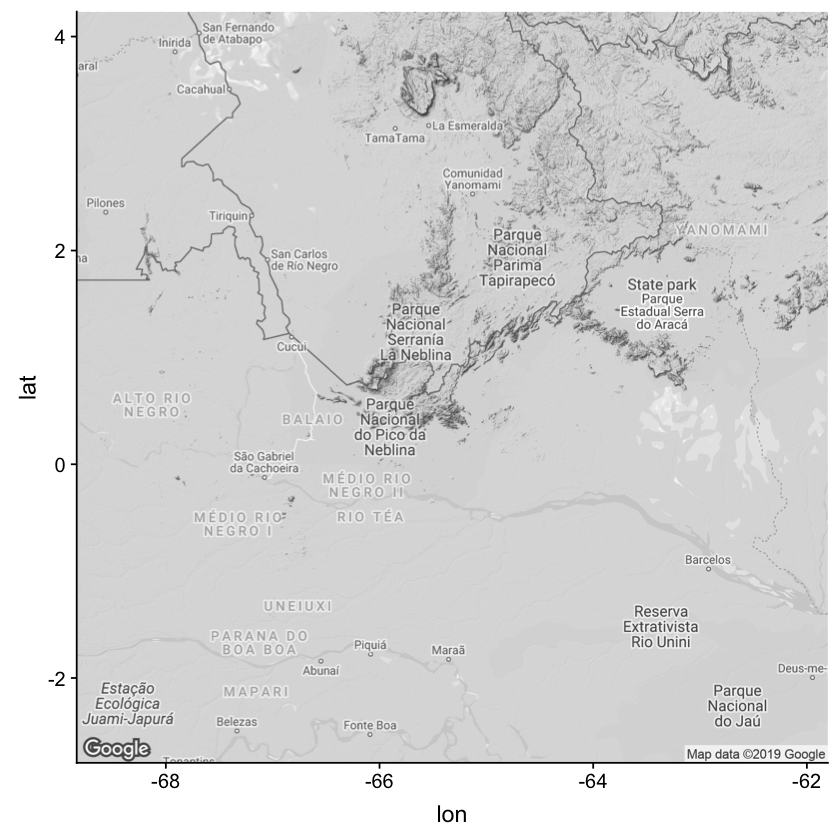

In [35]:
ggmap(mapa, extent = 'panel')

## 06 Plot the maps

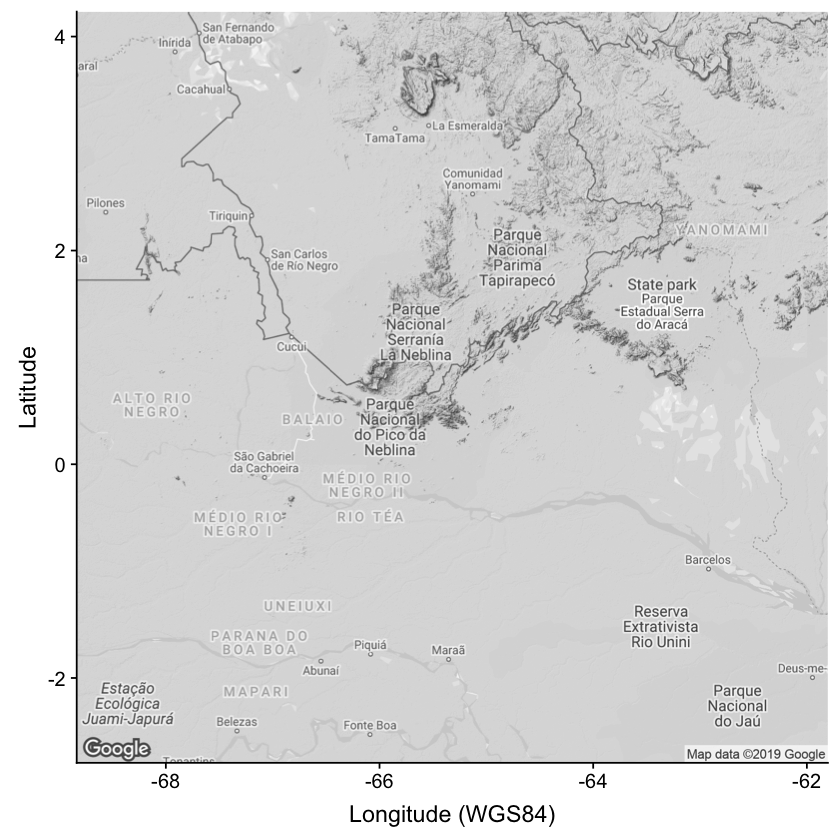

In [36]:
# Main map - species distribution
x_escala = -65.1

araca_map1 <- 
    ggmap(mapa, extent = 'panel') +
    xlab('Longitude (WGS84)') +
    ylab('Latitude')
araca_map1

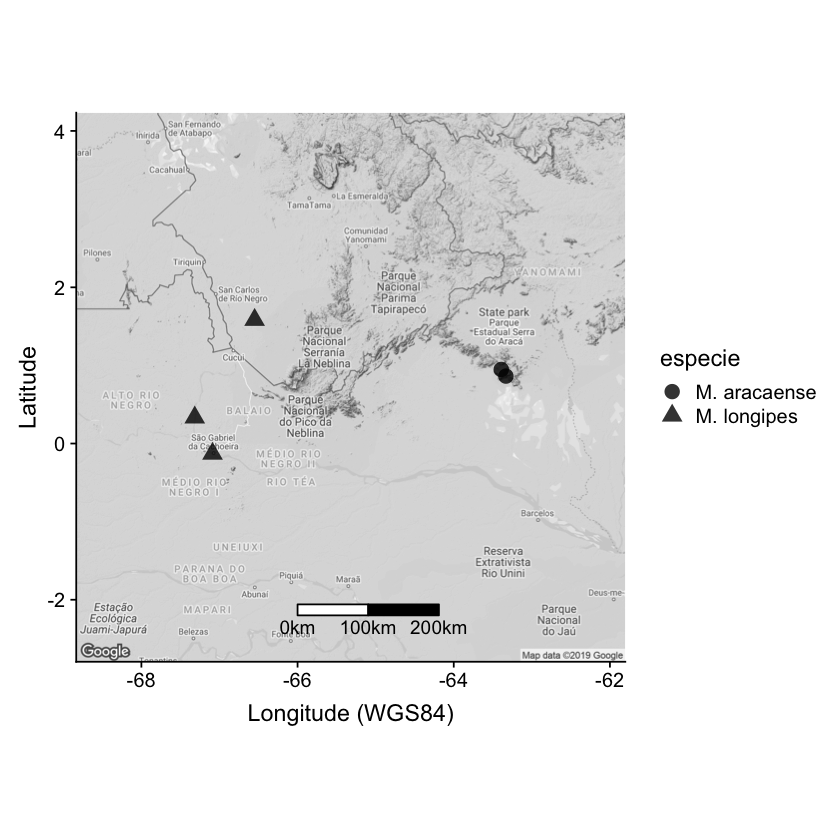

In [37]:
araca_map2 <- araca_map1 +
    geom_point(aes(x = long, y = lat, shape = especie), data = dados, alpha = .8, color ="black", size = 4) +
    scalebar(x.min = attr(mapa, "bb")[[2]], 
           y.min = attr(mapa, "bb")[[1]], 
           x.max = attr(mapa, "bb")[[4]], 
           y.max = attr(mapa, "bb")[[3]], 
           dist = 100, anchor = c(x=-66, y=-2.2), 
           dd2km = T, model = 'WGS84', location = "topleft", st.size = 4, st.dist = 0.02)
araca_map2

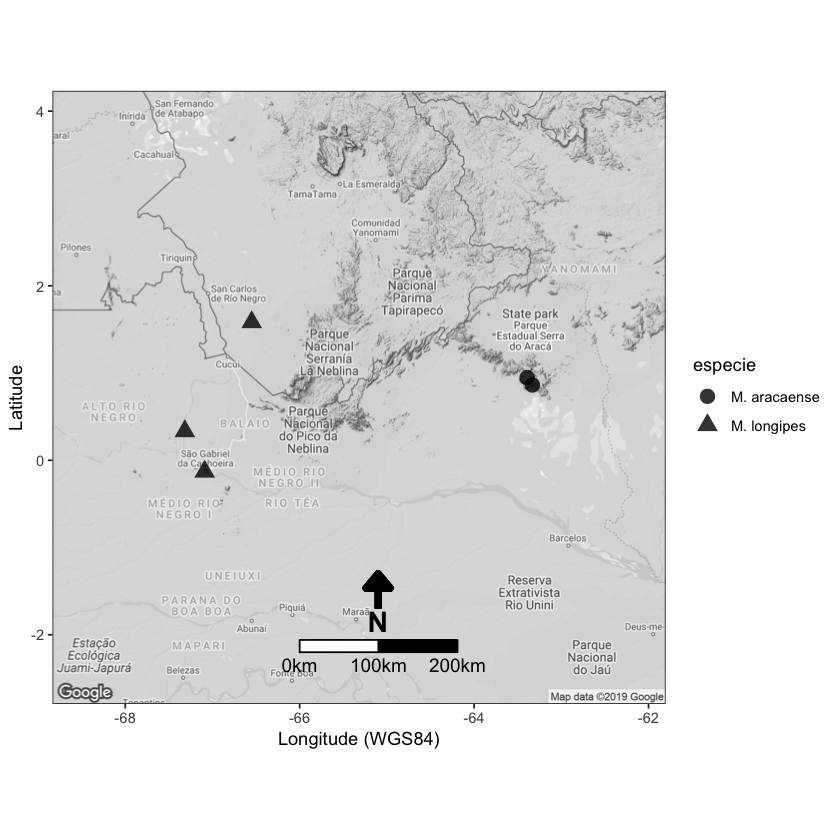

In [38]:
araca_map3 <- araca_map2 +
    geom_segment(arrow = arrow(length = unit(4,"mm"), type="closed", angle = 40), 
                 aes(x = x_escala, xend = x_escala,y = -1.7 , yend = -1.3), colour= 'black', size = 2) +
    annotate(x = x_escala, y = -1.85, label = 'N', color = 'black', geom = 'text', size = 6,
             fontface = 'bold') +
    theme_bw()
araca_map3

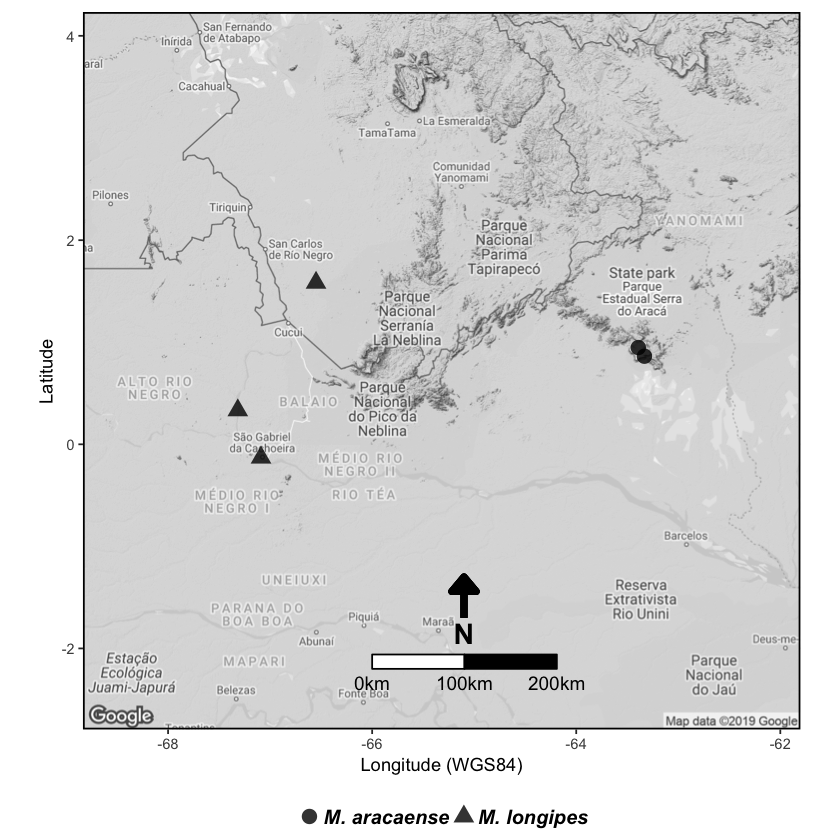

In [39]:
araca_map <- araca_map3 +
    theme(panel.border = element_rect(colour = "black", fill=NA, size=1),
          legend.title = element_blank(),legend.text = element_text(size = 12, face = 'bold.italic'),#family = 'Times New Roman'),
          legend.position = 'bottom',
          plot.margin = unit(x=c(0.1,0.1,0,0.1),units="in"))
araca_map

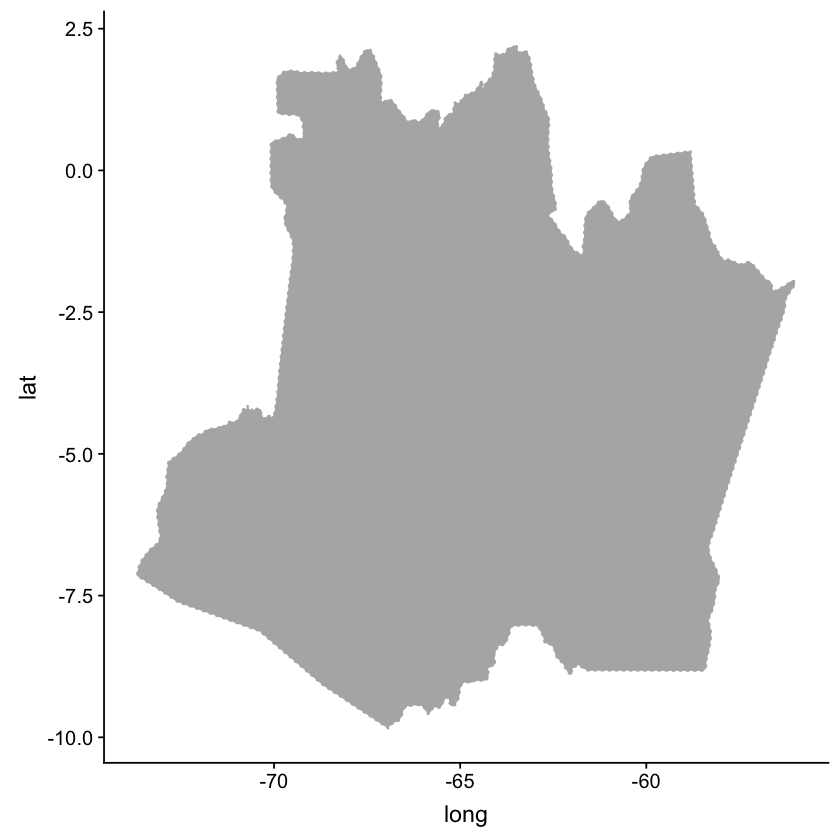

In [40]:
# plot the overview map
overviewmap1 <-
    ggplot() + 
    geom_polygon(data = br_amazonas_tidy,
                 aes(x = long, y = lat, group = group),
                 color = 'gray70', fill = 'gray70', linetype = 3)
overviewmap1

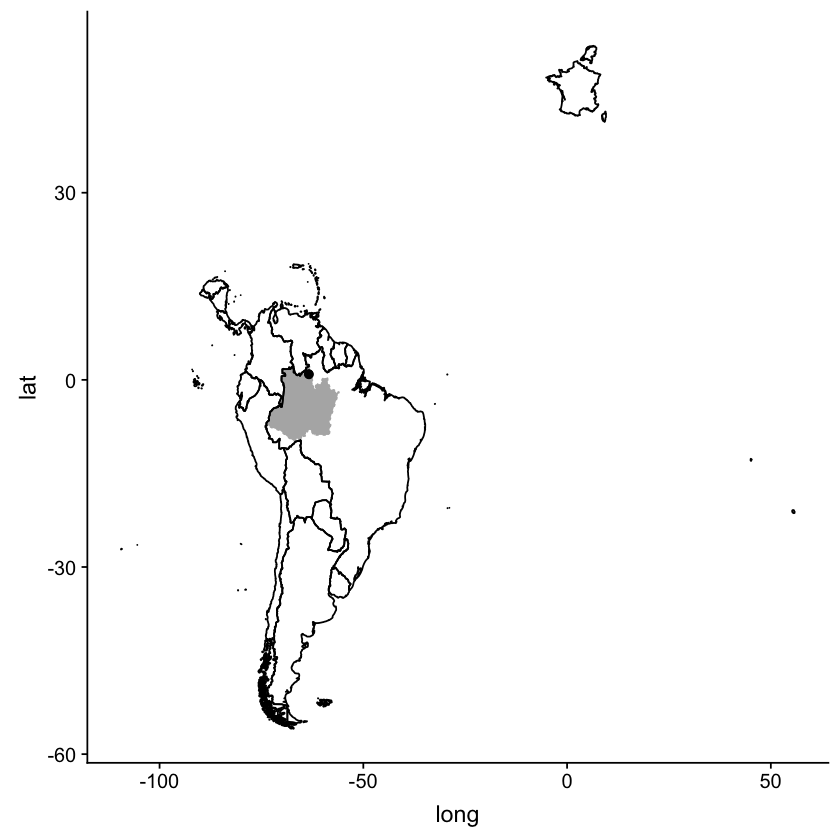

In [41]:
overviewmap2 <- overviewmap1 +
  geom_polygon(data = area_mapa_tidy,
               aes(long, lat, group = group), 
               color="black", fill=NA) +
    geom_point(data = subset(dados, especie %in%  'M. aracaense'), 
               aes(x = long, y = lat), size = 2,
               pch = 19, col = "black")
overviewmap2

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


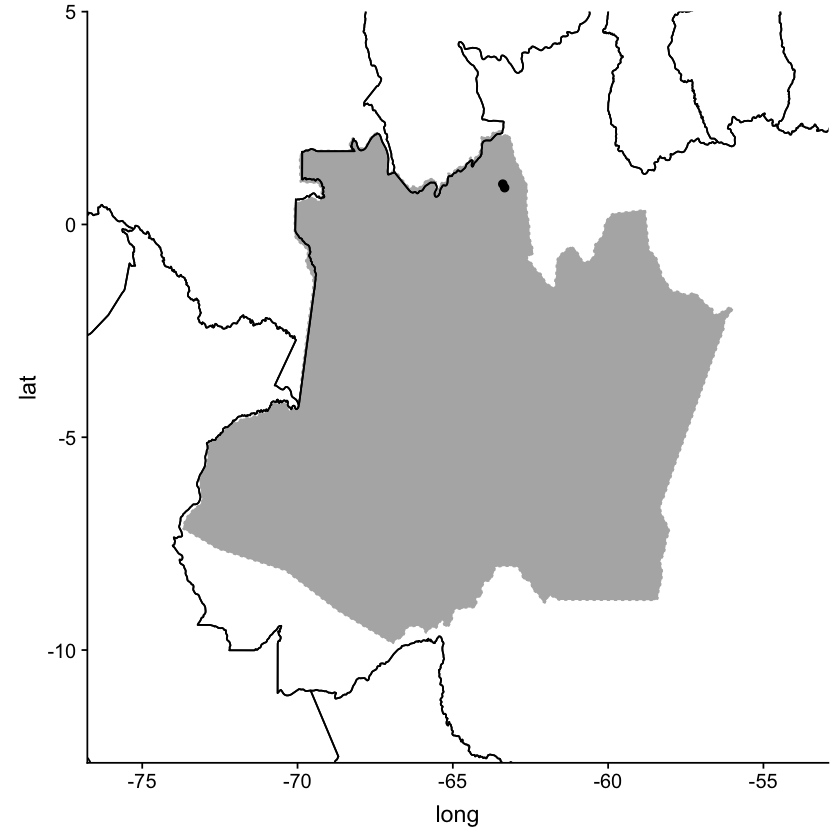

In [42]:
overviewmap3 <- overviewmap2 +
    coord_equal() +
    coord_cartesian(
    xlim = x1 - c(2,-2), ylim = y1 - c(2,-2) 
    ) 
overviewmap3

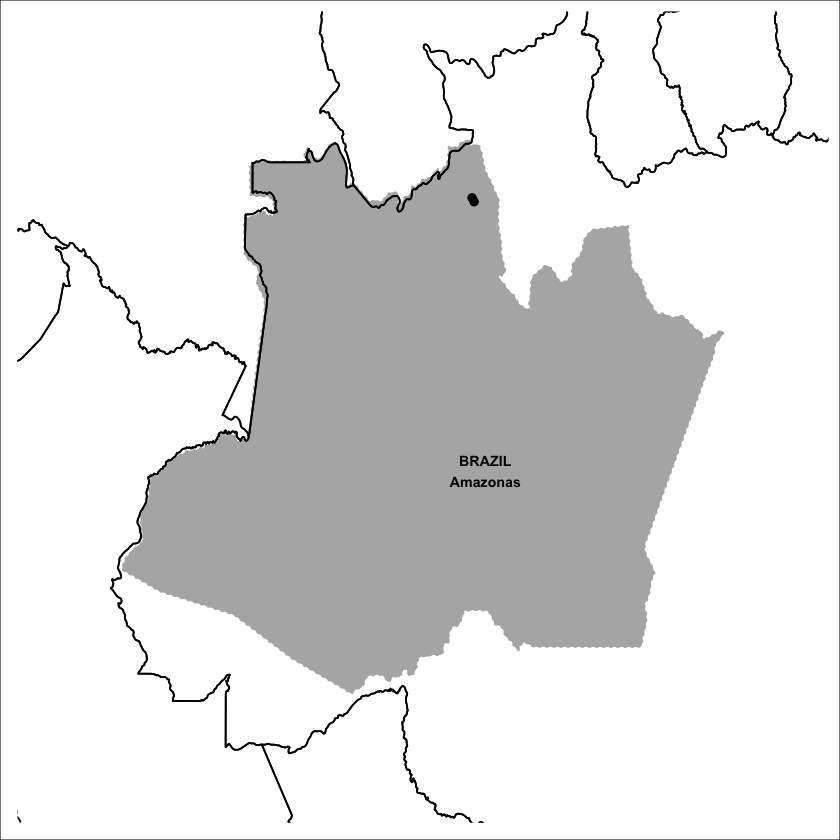

In [47]:
overviewmap <- overviewmap3 +
    theme(plot.background =
              element_rect(fill = "white", linetype = 1,
                           size = 0.3, colour = "black"),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          axis.title.x=element_blank(),
          axis.title.y=element_blank(),
          legend.position="none") +
    annotate(x = -63,y = -5,label = 'BRAZIL\nAmazonas',
             color = 'black', geom = 'text', 
             size = 3,fontface = 'bold') 
overviewmap

## 07 Combine the maps using R package *cowplot*

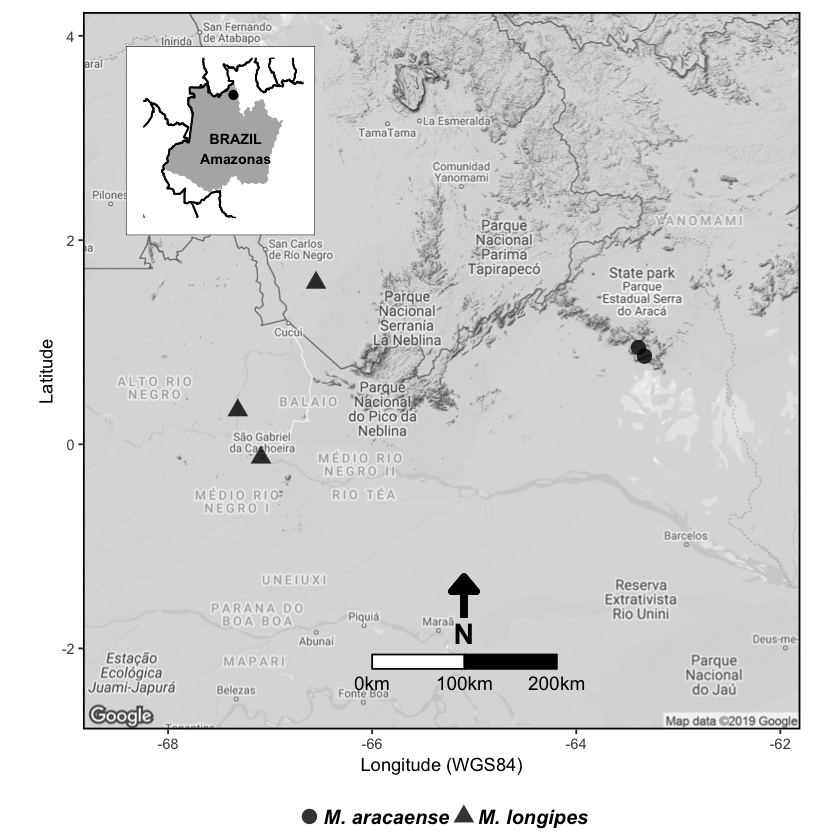

In [48]:
final_map <- ggdraw() +
    draw_plot(araca_map, 0, 0, 1, 1) +
    draw_plot(overviewmap, 0.15, 0.72, 0.225, 0.225)
final_map

## 08 Save the final map in your folder

In [49]:
cowplot::ggsave(
    plot = final_map, 
    filename = 'final_map_Macrolobium_aracaense_ggmap.pdf', dpi = 600, width = 6, height = 6, units = 'in')